# Internal Inconsistencies

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display
import import_ipynb
import data_preperation as dp
import copy
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import openpyxl


importing Jupyter notebook from data_preperation.ipynb


In [2]:
countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'UK'}

abbr_list=list(countries.values())

# load_data = dp.load(countries)
# generation_data = dp.generation(countries)
# cross_border_data = dp.cross_border(abbr_list)[1]
# import_export_using_crossborder_data = dp.import_export_using_crossborder(dp.cross_border(abbr_list)[0],abbr_list)

# 1. Internal inconsistencies based on unedited ENTSO-E data

## 1.1 Calculating missing values and mismatch analysis in data files

In [3]:
def omit_dst(df):

    # Due to day light saving, all the datasets have null values on 25th March from 02:00 - 03:00. 
    # Considering the time intervals each country update the data, a total number of rows of 4,2 or 1 are dropped from the 31st March, 02:00 - 03:00 time interval.
    # Also this returns a integer ('divider') based on the file length to get the energy values in a later step. In 15 min interval files this is 4, in 30 min interval files this is 2 and in 1 hour interval files this is 1.
    
    length = len(df)
    if length == 35044:
        df = df.drop(range(7976, 7980)).reset_index(drop=True)
        divider = 4
    elif length == 17522:
        df = df.drop(range(3988, 3990)).reset_index(drop=True)
        divider = 2
    else:
        df = df.drop(range(1994, 1995)).reset_index(drop=True)
        divider = 1
    
    return(df,divider)

def mismatch_raw_data(countries):

    load_missing_data = []
    generation_missing_data = []
    transmission_missing_data =[]
    transmission_data = pd.DataFrame()
    transmission_data_temp = pd.DataFrame()
    temp1 = pd.DataFrame()
    
    mismatch_data = {}
    temp = pd.DataFrame()
    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")

    # In the following command we read each csv file and drop the rows related to day light saving using 'omit_dst' function
    # We create a new dataframe 'transmission_data_temp' with all the columns in all the csvs attached together.
    # Then one by one we copy each csv to 'temp' dataframe and make all the 'n/e' values of the 'temp' 0.
    # Then we cretae two new column in the 'transmission_data' dataframe and name it as the two country codes the power transmission occurs.
    # We use string editing to get the two country codes from the file path.
    # Then we save the total number of null values in load data of each country in the load_missing_data list.
    # Then we save the total number of null values in generation data of each country in the generation_missing_data list.
    # Then we create a list of column names with all the columns of 'transmission_data_temp' if {country_abbreviations} is in the column name.
    # Then we save the total number of null values in each 'transmission_data_temp' dataframe of each country in the transmission_missing_data list using the filtered columns in the previous step.
    # Then we make a list of column heads of imports and exports associated with a given country_abbreviation
    # We calculate the annual data mismatch of each country as (generation + imports - load - exports) of the country.
    # Countries provide the data in 15 min, 30 min and 1 hour intervals.
    # Therefore to ge the energy values from the power values, we divide the total power data by 4,2 or 1 using the 'divider' variable as required.
    
    for csv in csvs:

        temp, divider_transmission = omit_dst(pd.read_csv(csv))
        transmission_data_temp = pd.concat([transmission_data_temp,temp.iloc[:,1:]],axis=1)

        temp=temp.replace(['n/e', np.nan], 0)
        transmission_data[f'{csv[42:44]} - > {csv[45:47]}'] = pd.to_numeric(temp.iloc[:, 2])/divider_transmission
        transmission_data[f'{csv[45:47]} - > {csv[42:44]}'] = pd.to_numeric(temp.iloc[:, 1])/divider_transmission
    
    for country,abbr in countries.items():
        load_data,divider_load = omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv'))
        generation_data, divider_gen = omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False))
        
        load_missing_data.append(load_data.isnull().sum().sum())
        generation_missing_data.append(generation_data.isnull().sum().sum())

        transmission_links = [x for x in transmission_data_temp.columns.values if abbr in x]
        transmission_missing_data.append(transmission_data_temp[transmission_links].isnull().sum().sum())

        imports=[x for x in transmission_data.columns.values if abbr in x[-2:]]
        exports=[x for x in transmission_data.columns.values if abbr in x[:2]]

        generation_data=generation_data.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'],axis=1)

        mismatch_data.update({f'{abbr}': [generation_data.iloc[:, 2:].sum(axis=1).sum()/divider_gen, transmission_data[imports].sum(
            axis=1).sum(), load_data.iloc[:, 2].sum()/divider_load, transmission_data[exports].sum(axis=1).sum(), round(abs(generation_data.iloc[:, 2:].sum(axis=1).sum()/divider_gen + transmission_data[imports].sum(
                axis=1).sum() - load_data.iloc[:, 2].sum()/divider_load - transmission_data[exports].sum(axis=1).sum())/1000000, 2)]})

    temp1['Country'] = list(countries.values())
    temp1['No. of missing data in Load data'] = load_missing_data
    temp1['No. of missing data in Generation data'] = generation_missing_data
    temp1['No. of missing data in Transmission data'] = transmission_missing_data
  
    mismatch_data_copy = mismatch_data.copy()
    mismatch_data_copy = sorted(mismatch_data_copy.items(), key= lambda item: item[1][-1], reverse=True)
    display(temp1)   

    width = 0.35
    labels = [x[0] for x in mismatch_data_copy]
    X = np.arange(len(labels))
    plt.figure(figsize=(20,10))
    plt.bar([x for x in X], [x[1][-1] for x in mismatch_data_copy], width, color='aqua',edgecolor='black')
    plt.xlabel('Countries')
    plt.ylabel('Mismatch [TWh]')
    plt.title('Mismatch analysis based on (generation + imports - load - exports) in raw ENTSO-E data')
    plt.grid()
    plt.xticks(X,labels)
    plt.show()

    return mismatch_data


# 2. Consolidation based on internally gap filled ENTSO-E data

## 2.1 Nearest Neighbours Mean value based internal approach

In [30]:
# In the following section we take each generation,load and transmission csvs and send them to the 'neareset_neighbours_mean' function.
# This function send each dataframe to 'omit_dst' function and removes the empty observations on March 28th and get the 'divider' value which is associated with the length of the dataframe.
# Then we replace 'n/e' values with 0
# Then we check the dataframe column by column.
# First we filter the columns in which the whole column is not 0 in the dataframe.
# Then we add the index and value of each value in the column to a list called 'column_data'
# Then we check value by value in the column untill a null value is found.
# If the value is a null value, we get all the values in that column which are the values associated with the same time step of the null value and the absolute difference of the indexes of that value and the null value to the 'temp_list'. 
# For example if the null value occurus at 10:00 - 10:15 time step of some day, all the values associated with 10:00 - 10:15 time step throughout the year and and the absolute difference of the indexes of those value and the null value go to the 'temp_list'
# Then the 'temp_list' is sorted and the first 60 values are taken to the 'nearest_neighbours' list
# Here in the 'nearest_neighbours' list we get the values of the nearest 60 days of the same time step in which the null value has occured.
# Then we replace any null values in the 'nearest_neighbours' list with 0
# Then we get the mean value of the 'nearest_neighbours' list and assign that value to the original null value in the dataframe

def nearest_neighbours_mean(df):
    edited_df = pd.DataFrame()
    df, divider = omit_dst(df)
    df=df.replace('n/e', 0)
    for column in df.columns.values:
        if not (df[column] == 0).all():
            column_data = [[index, value] for index, value in enumerate(df.loc[:, column])]
            for index, value in column_data:
                if pd.isnull(value):
                    temp_list = [[abs(index-item[0]),item[1]] for item in column_data if (index-item[0]) % (24*divider) == 0]
                    temp_list.sort()
                    nearest_neighbours = [x[1] for x in temp_list[:60]]
                    nearest_neighbours = [0 if pd.isna(x) else x for x in nearest_neighbours]
                    df.loc[index, column] = np.mean(np.array(nearest_neighbours))
            edited_df = pd.concat([edited_df, df.loc[:, column]], axis=1)
    return edited_df

def internal_mean(countries):
    for country,abbr in countries.items():
        df_load = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv').iloc[:,2:]
        df_load = df_load.rename(columns={df_load.columns[0]: 'demand'})
        load_consolidated_nnm = nearest_neighbours_mean(df_load)
        load_consolidated_nnm.to_csv(f'../Data Sources/output/Nearest Neighbours Mean/Load/{abbr}.csv')

        df_gen = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv').iloc[:,2:]
        df_gen = df_gen.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'],axis=1)
        gen_consolidated_nnm = nearest_neighbours_mean(df_gen)
        gen_consolidated_nnm.to_csv(f'../Data Sources/output/Nearest Neighbours Mean/Generation/{abbr}.csv')
    print('LOAD & GENERATION DATA COSOLIDATED')

    transmission_consolidated_nnm =pd.DataFrame()
    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")
    for csv in csvs:
        df = pd.read_csv(csv).iloc[:, 1:]
        df = df.rename(columns={df.columns[0]: f'{csv[45:47]} - > {csv[42:44]}',df.columns[1]: f'{csv[42:44]} - > {csv[45:47]}'})
        transmission_consolidated_nnm = pd.concat([transmission_consolidated_nnm,nearest_neighbours_mean(df)],axis=1)
    transmission_consolidated_nnm.to_csv('../Data Sources/output/Nearest Neighbours Mean/Transmission/transmisson.csv')
    print('TRANSMISSION DATA COSOLIDATED')


## 2.2 Optimization based internal approach

In [9]:
def internal_sigma(load_dic, generation_dic, transmission_data, countries):

    abbr_list = list(countries.values())
    load_dic_copy = copy.deepcopy(load_dic)
    generation_dic_copy = copy.deepcopy(generation_dic)
    transmission_data_copy = copy.deepcopy(transmission_data)

    # In the following command, we calculate the sigma value by sending it to 'data_preperation.ipynb'

    sigma = dp.sigma(load_dic_copy, generation_dic_copy, transmission_data_copy, abbr_list)
    print('SIGMA CALCULATED')

    # In the follwoing commands we create a 'country_index' with the names abbreviations of the 27 countries we consider.
    # Then we create a 'time_index' which is a list of integers from 0 to 8760 which indicates the timesteps 
    # Then we create a 'generation_index' which is a dictionary with country_abbreviations as keys and generation_sources os each country as the values of each key.
    # Then we create a 'generation_fuels' which is a list of all the generation_sources we consider.
    # Then we create 2 dictionaries 'imports_index' and 'exports_index' with country_abbreviations as the keys.
    # In the column heads of 'transmission_data' dataframe, if the name of the key is in the first two characters of the column head, that column head goes as the value in 'export_index' dictionary
    # In the column heads of 'transmission_data' dataframe, if the name of the key is in the last two characters of the column head, that column head goes as the value in 'import_index' dictionary
    # Then we create a 'transmission_index' with all the column heads of 'transmission_data' dataframe.

    country_index = list(countries.values())
    time_index = np.arange(8761, dtype=int)

    generation_index = {}

    for abbr, df in generation_dic.items():
        generation_index[abbr] = [x for x in df.columns.values]

    generation_fuels = np.array(list(set([item for sublist in generation_index.values() for item in sublist])))
    generation_fuels.sort()

    imports_index = {}
    exports_index = {}

    for abbr in abbr_list:
        imports_index[abbr] = [x for x in transmission_data.columns.values if abbr in x[-2:]]
        exports_index[abbr] = [x for x in transmission_data.columns.values if abbr in x[:2]]

    transmission_index = np.array(transmission_data.columns.values)
    transmission_index.sort()

    # In the following commands, we initiate the pyomo optimization with 'Gurobi' solver
    # We declare the three variables 'delta_generation', 'delta_load' and 'delta_transmission'
    # 'delta_generation' consists of 2,207,520 values which vary with country, generation_source and timestep.
    # 'delta_load' consists of 236,520 values which vary with country and timestep.
    # 'delta_transmission' consists of 858,480 values which vary with timestep and with country indirectly.
    # We declare the model constraint as the sum of (delta_generation + generation + delta_transmission(imports) + imports) is equal to the sum of (delta_load + load + delta_transmission(exports) + exports) in all time steps.
    # We declare objective function as to MINIMIZE the sum of (delta_generation^2 * sigma(generaion)) + sum of (delta_load^2 * sigma(load)) + sum of (delta_transmission^2 * sigma(transmission)) in all timesteps.
    # Then solve the model.

    model = pyo.ConcreteModel()

    model.country_index = pyo.Set(initialize=country_index)
    model.time_index = pyo.Set(initialize=time_index)
    model.generation_fuels = pyo.Set(initialize=generation_fuels)
    model.transmission_index = pyo.Set(initialize=transmission_index)

    model.delta_generation = pyo.Var(model.country_index, model.time_index, model.generation_fuels, bounds=(0.0, None))
    model.delta_load = pyo.Var(model.country_index, model.time_index, bounds=(0.0, None))
    model.delta_transmission = pyo.Var(model.time_index, model.transmission_index, bounds=(0.0, None))

    print('VARIABLES DECLARED')

    def balance_rule(model, country, time):
        return sum(model.delta_generation[country, time, generation] + generation_dic[country][generation][time] for generation in generation_index[country]) + sum(model.delta_transmission[time, link] + transmission_data[link][time] for link in imports_index[country]) ==  \
            model.delta_load[country, time] + load_dic[country]["demand"][time] + \
            sum(model.delta_transmission[time, link] + transmission_data[link][time] for link in exports_index[country])
    model.balance_rule = pyo.Constraint(model.country_index, model.time_index, rule=balance_rule)

    def ObjRule(model):
        return sum(model.delta_generation[country, time, generation] ** 2 * float(sigma[country][generation].iloc[time]) for country in model.country_index for time in model.time_index for generation in generation_index[country]) \
            + sum(model.delta_transmission[time, link] ** 2 * float(sigma["transmission_data"][link].iloc[time]) for time in model.time_index for link in model.transmission_index)\
            + sum(model.delta_load[country, time] ** 2 * float(sigma[country]["demand"].iloc[time]) for country in model.country_index for time in model.time_index)

    model.obj = pyo.Objective(rule=ObjRule, sense=pyo.minimize)
    opt = SolverFactory("gurobi", solver_io="python")
    opt.solve(model)
    print('OPTIMIZATION COMPLETED')

    # In the following commands we copy the pyomo results into different intermediary variables.
    # We create 'intermediary_var' dictionary and inside it create two other dictionaries as keys called 'generation' and 'load' and create a dataframe as another key called 'transmission'.
    # We create 'unit_var' dictionary and inside it create two other dictionaries as keys called 'generation' and 'load' and create a dataframe as another key called 'transmission'.
    # We fill the 'intermediary_var["generation"]' from the 'delta_generation' values and 'intermediary_var["load"]' with 'delta_load' values and 'intermediary_var["transmission"]' from 'delta_transmission' values.
    # We fill 'unit_var["generation"]', 'unit_var["load"]' and 'unit_var["transmission"]' which have the same size as of 'intermediary_var["generation"]', 'intermediary_var["load"]' and ''intermediary_var["transmission"]' with integer 1.

    generation_index_copy = copy.deepcopy(generation_index)

    intermediary_var = {}
    intermediary_var["generation"] = {}
    intermediary_var["load"] = {}
    unit_var = {}
    unit_var["generation"] = {}
    unit_var["load"] = {}

    for country in country_index:
        table_gen = []
        row_load = []
        for time in time_index:
            row_gen = []
            for generation in generation_index_copy[country]:
                row_gen.append(model.delta_generation[country, time, generation].value)
            table_gen.append(row_gen)
            row_load.append(model.delta_load[country, time].value)

        intermediary_var["generation"][country] = pd.DataFrame.from_records(table_gen)
        intermediary_var["load"][country] = pd.DataFrame(row_load)
        intermediary_var["generation"][country].columns = generation_index_copy[country]
        intermediary_var["load"][country].columns = ['demand']
        intermediary_var["generation"][country].to_csv("../Data Sources/output/Internal Sigma/Debugging/" + "internal_sigma_gen_" + country + ".csv")
        intermediary_var["load"][country].to_csv("../Data Sources/output/Internal Sigma/Debugging/" + "internal_sigma_load_" + country + ".csv")
        unit_var["generation"][country] = pd.DataFrame(1, index=np.arange(df.shape[0]), columns=generation_index_copy[country])
        unit_var["load"][country] = pd.DataFrame(1, index=np.arange(df.shape[0]), columns=['demand'])

    table_transmission = []

    for time in time_index:
        row = []
        for link in transmission_index:
            row.append(model.delta_transmission[time, link].value)
        table_transmission.append(row)
    intermediary_var["transmission"] = pd.DataFrame.from_records(table_transmission)
    intermediary_var["transmission"].columns = transmission_index
    intermediary_var["transmission"].to_csv("../Data Sources/output/Internal Sigma/Debugging/internal_sigma_transmission.csv")
    unit_var["transmission"] = pd.DataFrame(1, index=np.arange(transmission_data.shape[0]), columns=transmission_data.columns)

    generation_dic_copy = copy.deepcopy(generation_dic)
    transmission_data_copy = copy.deepcopy(transmission_data)

    # We send the intermediary_var and unit_var to 'data_preperation.ipynb' to get the consolidated generation,load and transmission values.

    consolidated_gen_data, consolidated_load_data, consolidated_transmission_data = dp.data_consolidation(generation_dic_copy, load_dic, transmission_data_copy, intermediary_var, unit_var)

    return(consolidated_gen_data, consolidated_load_data, consolidated_transmission_data)


## 2.2 Mismatch analysis in the consolidated ENTSO-E data

In [10]:
# def mismatch_consolidated_data(consolidated_gen_data, consolidated_load_data, consolidated_transmission_data, countries):

#     # In the above consolidated ENTSO-E data, we carry out a mismatch analysis using anuual (generation + imports - load - exports) in each country.
    
#     temp_dic = {}

#     temp_transmission = pd.read_csv('../Data Sources/output/Internal Sigma/Reconciled data/Transmission/all_transmissions.csv')

#     for country,abbr in countries.items():
#         temp_gen = pd.read_csv(f'../Data Sources/output/Internal Sigma/Reconciled data/Generation/{abbr}.csv').iloc[:, 1:]
#         temp_load = pd.read_csv(f'../Data Sources/output/Internal Sigma/Reconciled data/Load/{abbr}.csv').iloc[:, 1:]

#         temp_dic.update({country: [temp_gen.sum(axis=1).sum(), temp_transmission.filter(like=f'> {abbr}').sum(axis=1).sum(), temp_load.sum(), temp_transmission.filter(like=f'{abbr} -').sum(
#             axis=1).sum()]})

#     mismatch_data = pd.DataFrame(columns=['Country', 'Generation [GWh]', 'Imports [GWh]', 'Demand [GWh]', 'Exports [GWh]', 'Mismatch [GWh]'])
#     mismatch_data.iloc[:, 0] = temp_dic.keys()

#     for i in range(4):
#         mismatch_data.iloc[:,i+1] = [round(x[i]/1000,2) for x in temp_dic.values()]
#     mismatch_data.iloc[:,5] = abs(mismatch_data.iloc[:,1] + mismatch_data.iloc[:,2] - mismatch_data.iloc[:,3] - mismatch_data.iloc[:,4])

#     display(mismatch_data)


In [42]:
def mismatch_consolidated_data(mismatch_data,countries):

    consolidated_mismatch_data = pd.DataFrame(columns=['Country', 'Generation raw data[%]', 'Generation consolidated data[%]', 'Imports raw data[%]',
                                          'Imports consolidated data[%]', 'Demand raw data[%]', 'Demand consolidated data[%]', 'Exports raw data[%]', 'Exports consolidated data[%]'])
    
    temp_transmission = pd.read_csv('../Data Sources/output/Internal Sigma/Reconciled data/Transmission/all_transmissions.csv').iloc[:, 1:]
    total_generation_raw=total_load_raw= total_imports_raw= total_exports_raw=total_generation_consolidated= total_load_consolidated= total_imports_consolidated= total_exports_consolidated = 0
    stat_data = pd.read_excel('../Data Sources/ENTSO-E/entsoe_sfs2018_web.xlsx').iloc[1:28,].reset_index(drop=True)
    stat_data = stat_data[['Country','Total net generation', 'Consumption', 'Sum of imports','Sum of exports']]

    for index,row in stat_data.iterrows():
        abbr = row[0]
        temp_gen = pd.read_csv(f'../Data Sources/output/Internal Sigma/Reconciled data/Generation/{abbr}.csv').iloc[:, 1:]
        temp_load = pd.read_csv(f'../Data Sources/output/Internal Sigma/Reconciled data/Load/{abbr}.csv').iloc[:, 1:]
        imports = [x for x in temp_transmission.columns.values if abbr in x[-2:]]
        exports = [x for x in temp_transmission.columns.values if abbr in x[:2]]

        total_generation_raw+=mismatch_data[abbr][0]/1000000
        total_imports_raw+=mismatch_data[abbr][1]/1000000
        total_load_raw+=mismatch_data[abbr][2]/1000000
        total_exports_raw+=mismatch_data[abbr][3]/1000000
        total_generation_consolidated+=temp_gen.sum(axis=1).sum()/1000000
        total_imports_consolidated+=temp_transmission[imports].sum(axis=1).sum()/1000000
        total_load_consolidated+=temp_load['demand'].sum()/1000000
        total_exports_consolidated+=temp_transmission[exports].sum(axis=1).sum()/1000000
      
    value_1 =(stat_data['Total net generation'].sum()-total_generation_raw)*100/stat_data['Total net generation'].sum()
    value_2 =(stat_data['Total net generation'].sum()-total_generation_consolidated)*100/stat_data['Total net generation'].sum()

    value_3 =(stat_data['Sum of imports'].sum()/1000-total_imports_raw)*100/(stat_data['Sum of imports'].sum()/1000)
    value_4 =(stat_data['Sum of imports'].sum()/1000-total_imports_consolidated)*100/(stat_data['Sum of imports'].sum()/1000)

    value_5 =(stat_data['Consumption'].sum()-total_load_raw)*100/stat_data['Consumption'].sum()
    value_6 =(stat_data['Consumption'].sum()-total_load_consolidated)*100/stat_data['Consumption'].sum()

    value_7 =(stat_data['Sum of exports'].sum()/1000-total_exports_raw)*100/(stat_data['Sum of exports'].sum()/1000)
    value_8 =(stat_data['Sum of exports'].sum()/1000-total_exports_consolidated)*100/(stat_data['Sum of exports'].sum()/1000)

    x1=[value_1,value_3,value_5,value_7]
    x2=[value_2,value_4,value_6,value_8]

    width = 0.35
    labels = ['Actual generation per type','Physical flow imports','Actual load','Physical flow exports']
    X = np.arange(4)
    plt.figure(figsize=(10, 5))
    plt.bar([x-width/2 for x in X], x1, width,color='magenta', edgecolor='black', label='Raw data')
    plt.bar([x+width/2 for x in X], x2, width,color='aqua', edgecolor='black', label='Consolidated data')
    plt.xlabel('Data Items')
    plt.ylabel('Percentage difference')
    plt.title('Percentage difference with respect to ENTSO-E statistical data - 2018')
    plt.legend()
    plt.grid()
    plt.xticks(X, labels)
    plt.show()


,Country,No. of missing data in Load data,No. of missing data in Generation data,No. of missing data in Transmission data
0,AT,0,0,0
1,BE,0,8027,50
2,BG,26,8760,1732
3,CH,0,8760,0
4,CZ,7,44,0
5,DE,96,34848,36
6,DK,0,0,0
7,EE,168,2266,4437
8,ES,2,8780,0
9,FI,3,28,429


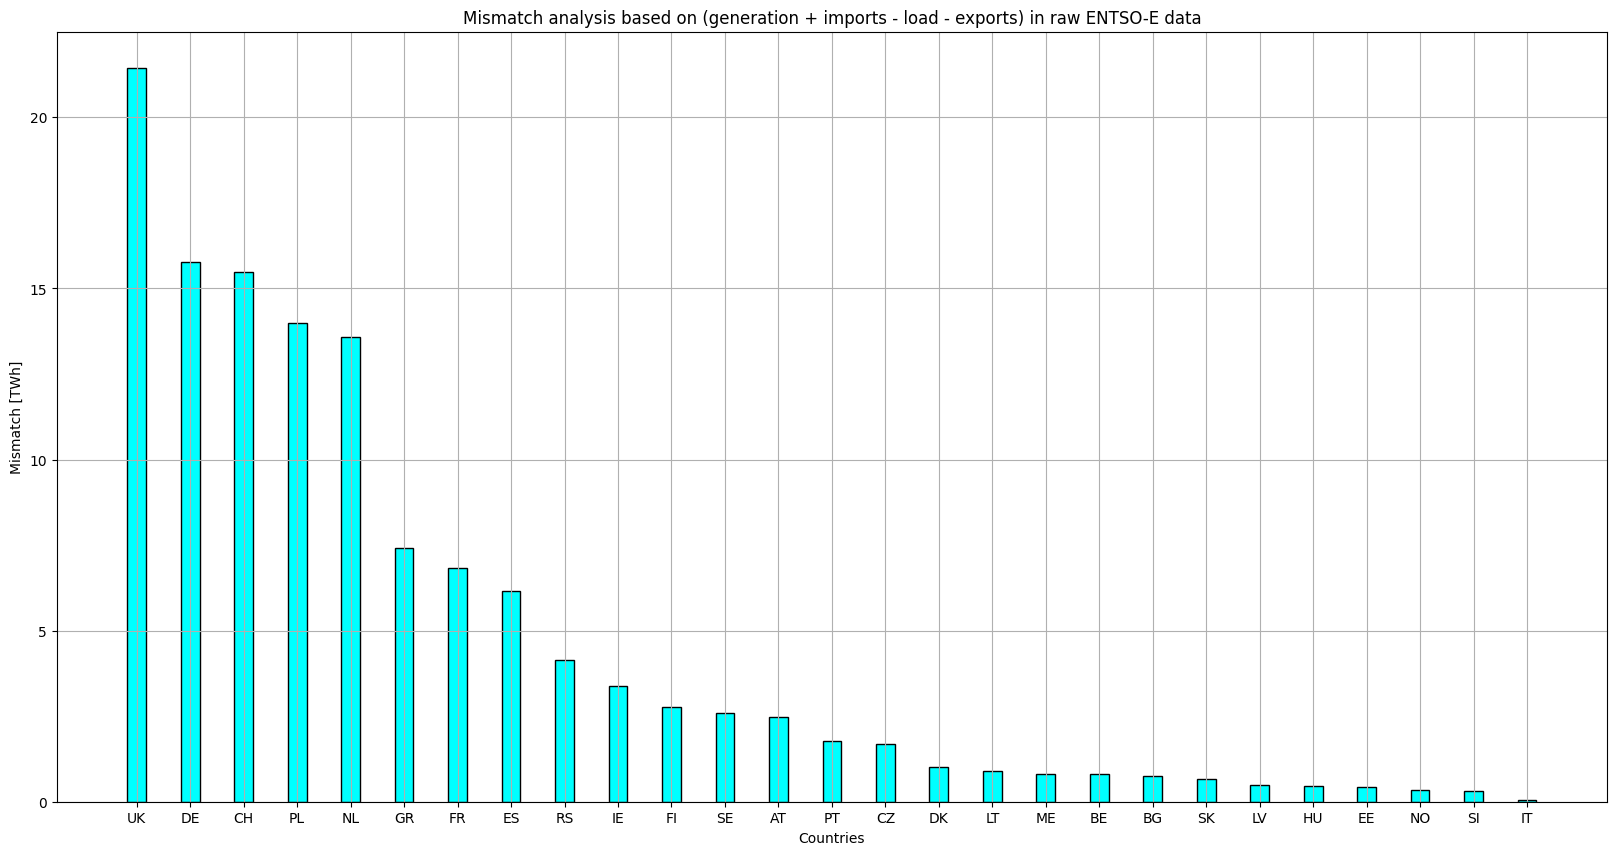

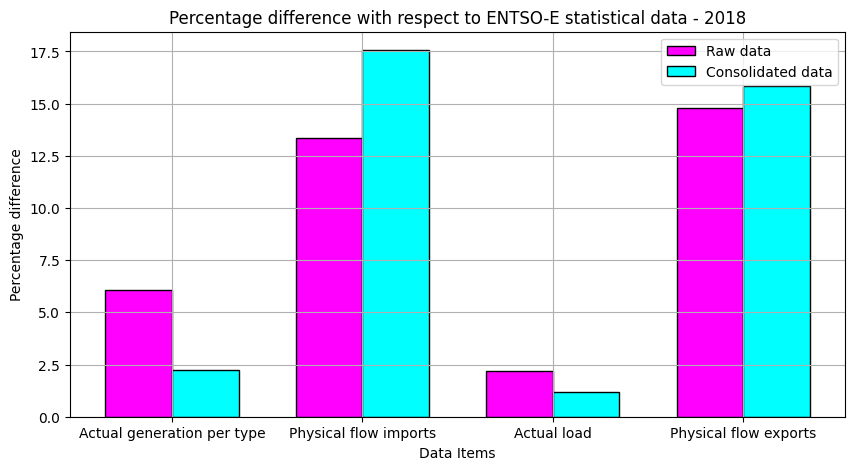

In [43]:
# mismatch_consolidated_data(mismatch_raw_data(countries),countries)
